In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import csv data
df = pd.read_csv('..\\Data\\all_pitches.csv')

In [3]:
df.head()

,game_id,batSide_code,batSide_des,batter,batter_id,call_des,inning_top_bot,pitchHand_code,pitchHand_des,pitch_type,...,strike_left,strike_down_right,strike_down,strike_down_left,call_B,call_C,call_F,call_H,call_S,is_out
0,413661,L,Left,Matt Carpenter,572761,Called Strike,top,L,Left,FF,...,0,0,0,0,0,1,0,0,0,0
1,413661,L,Left,Matt Carpenter,572761,Swinging Strike,top,L,Left,FF,...,0,0,0,0,0,0,0,0,1,0
2,413661,L,Left,Matt Carpenter,572761,Foul,top,L,Left,FF,...,0,0,0,0,0,0,1,0,0,0
3,413661,L,Left,Matt Carpenter,572761,Ball,top,L,Left,FF,...,0,0,0,0,1,0,0,0,0,0
4,413661,L,Left,Matt Carpenter,572761,Ball,top,L,Left,CU,...,0,0,0,0,1,0,0,0,0,0


# Exploratory Data Analysis

For this project, we want to find out if we can optimize a pitcher's pitch count to get more outs in less pitches. More specifically, which pitches tend to be most effective against which batters and in what location? It's a common expression to pitch "hard stuff in, soft stuff away"; basically to pitch fastballs closer to a batter in the strikezone and off-speed pitches futher away from the batter. This analysis will look into that idiom and determine which pitches, and where, tend to lead to outs.

In [4]:
# Separate target variables
target_cols = ['call_B', 'call_C', 'call_F', 'call_H', 'call_S', 'is_out']

In [5]:
targets = df[target_cols]

In [6]:
targets.head()

,call_B,call_C,call_F,call_H,call_S,is_out
0,0,1,0,0,0,0
1,0,0,0,0,1,0
2,0,0,1,0,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0


First we need to look at how often an outcome occurred when a pitch was thrown throughout the 2015-2017 MLB seasons.

In [7]:
# Print percentage of pitches produced which outcomes
print("%i pitches from the 2015-2017 seasons are being analyzed." % len(targets))
targets.mean()

2129403 pitches from the 2015-2017 seasons are being analyzed.


call_B    0.360146
call_C    0.168416
call_F    0.173895
call_H    0.064159
call_S    0.114559
is_out    0.173634
dtype: float64

Note that the percentage of outcomes are near each other with ``call_B``, balls, and ``call_H``, hits, being the biggest disparity. It's also worth mentioning that the percentages add up to more than 1 and that's due to the ``is_out`` column. There are a number of ways a batter could be out, one of which would be to strikeout which would result in ``call_C``, or ``call_S``, being ``1``as well as ``is_out``. This leads to double counting which isn't a bad thing because I want the model to learn that getting 3 strikes is an out.

### Pitch Type & Location

When looking at the data, it's obvious that the different pitch types and locations are broken down into dummy variables. Although this will be useful when modeling the data, it proves a problem when doing exploratory data analysis so the first thing to do is to switch them back into categorical columns.

In [8]:
# Separate pitch types and pitch locations
pitch_types_dummies = df.filter(regex="pitch_type_*")

In [9]:
pitch_types_dummies.head()

,pitch_type,pitch_type_Changeup,pitch_type_Curveball,pitch_type_Cutter,pitch_type_Eephus,pitch_type_Fastball,pitch_type_Forkball,pitch_type_Four-Seam Fastball,pitch_type_Int. Ball,pitch_type_Knuckle Curve,pitch_type_Knuckleball,pitch_type_Pitchout,pitch_type_Screwball,pitch_type_Sinker,pitch_type_Slider,pitch_type_Splitter,pitch_type_Two-Seam Fastball,pitch_type_Unknown
0,FF,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,FF,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,FF,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,FF,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,CU,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
# Use stack to collapse the columns into 1
pitch_types = pitch_types_dummies[pitch_types_dummies==1].stack().reset_index().drop(['level_0', 0], 1)

In [11]:
pitch_types.columns = ['pitch_type']
pitch_types.head()

,pitch_type
0,pitch_type_Four-Seam Fastball
1,pitch_type_Four-Seam Fastball
2,pitch_type_Four-Seam Fastball
3,pitch_type_Four-Seam Fastball
4,pitch_type_Curveball


In [12]:
# Set strikezone divisions
# Consider importing these in the future
sz_top = 3.406
sz_bot = 1.321
sz_right = -1.181
sz_left = 1.133
sz_top_third = 2.711
sz_bot_third = 2.016
sz_right_third = -0.410
sz_left_third = 0.362

In [13]:
df.loc[df['pitch_locx'] < sz_right, 'loc_x'] = 'ballX_right'
df.loc[(df['pitch_locx'] > sz_right) & (df['pitch_locx'] < sz_right_third), 'loc_x'] = 'strikeX_right'
df.loc[(df['pitch_locx'] > sz_right_third) & (df['pitch_locx'] < sz_left_third), 'loc_x'] = 'strikeX_mid'
df.loc[(df['pitch_locx'] > sz_left_third) & (df['pitch_locx'] < sz_left), 'loc_x'] = 'strikeX_left'
df.loc[(df['pitch_locx'] > sz_left), 'loc_x']= 'ballX_left'

In [14]:
df.loc[df['pitch_locy'] < sz_bot, 'loc_y'] = 'ballY_bot'
df.loc[(df['pitch_locy'] > sz_bot) & (df['pitch_locy'] < sz_bot_third), 'loc_y'] = 'strikeY_bot'
df.loc[(df['pitch_locy'] > sz_bot_third) & (df['pitch_locy'] < sz_top_third), 'loc_y'] = 'strikeY_mid'
df.loc[(df['pitch_locy'] > sz_top_third) & (df['pitch_locy'] < sz_top), 'loc_y'] = 'strikeY_top'
df.loc[(df['pitch_locy'] > sz_top), 'loc_y']= 'ballY_top'

Now that the dummy variables have been condensed and pitch locations categorized, a new data frame can be created to do some exploratory data analysis.

In [15]:
# Filter out relevant columns to keep from df
eda_df = df[['batSide_des', 'pitchHand_des', 'count_balls', 'count_strikes', 'inning_num', 'pitch_speed', 'loc_x', 'loc_y']]

In [16]:
# Join targets, pitch_types, pitch_locs
eda_df = eda_df.join([pitch_types, targets])
eda_df.head()

,batSide_des,pitchHand_des,count_balls,count_strikes,inning_num,pitch_speed,loc_x,loc_y,pitch_type,call_B,call_C,call_F,call_H,call_S,is_out
0,Left,Left,0,0,1,92.9,strikeX_left,strikeY_top,pitch_type_Four-Seam Fastball,0,1,0,0,0,0
1,Left,Left,0,1,1,92.8,strikeX_mid,strikeY_mid,pitch_type_Four-Seam Fastball,0,0,0,0,1,0
2,Left,Left,0,2,1,94.1,strikeX_right,strikeY_top,pitch_type_Four-Seam Fastball,0,0,1,0,0,0
3,Left,Left,0,2,1,91.0,strikeX_right,ballY_bot,pitch_type_Four-Seam Fastball,1,0,0,0,0,0
4,Left,Left,1,2,1,75.4,ballX_right,strikeY_mid,pitch_type_Curveball,1,0,0,0,0,0


## Outs vs. Hits

This premise behind this project is to determine if there's a pattern to getting outs or not getting outs. Do high curveballs lead to more hits? Does the idiom "hard stuff in, soft stuff away" hold true? These are a couple of patterns to look into in this analysis. The function below takes in the data being used, which side the batter is hitting from, the pitcher's pitching hand, pitch type thrown and outcome of the pitch as parameters and returns the mean and count matrix of how often the pitches thrown at a specific location produced the outcome specified. It also displays heat maps as an indicator.

In [58]:
# Group outs by batSide, pitchHand, pitch_type, pitch_loc
def heat_map(data, bat_side, pitch_hand, pitch_type, call):
    '''Plot and return number of a certain pitch is thrown to a certain batter by a certain pitcher given the outcome call.
    Should plot two heat maps. The first is percent of outs in regards to the parameters. The second is total number of
    pitches produced the outcome call.'''
    pitch_cat = 'pitch_type_' + pitch_type
    hm_df = data[(data['batSide_des'] == bat_side) & (data['pitchHand_des'] == pitch_hand) & (data['pitch_type'] == pitch_cat)]
    
    # Pivot hm_df to take average of outcome call by location
    hm_df_call = hm_df[['loc_x', 'loc_y', call]]
    hm_pivot_mean = hm_df_call.pivot_table(index='loc_y', columns='loc_x', values=call, aggfunc='mean')
    hm_pivot_mean = hm_pivot_mean.reindex(['ballX_right', 'strikeX_right', 'strikeX_mid', 'strikeX_left', 'ballX_left'], axis=1)
    hm_pivot_mean = hm_pivot_mean.reindex(['ballY_top', 'strikeY_top', 'strikeY_mid', 'strikeY_bot', 'ballY_bot'], axis=0)
    
    # Pivot hm_df to take count of outcome call by location
    hm_df_count = hm_df[hm_df[call] == 1]
    hm_df_count = hm_df_count[['loc_x', 'loc_y', call]]
    hm_pivot_count = hm_df_count.pivot_table(index='loc_y', columns='loc_x', values=call, aggfunc='count')
    hm_pivot_count = hm_pivot_count.reindex(['ballX_right', 'strikeX_right', 'strikeX_mid', 'strikeX_left', 'ballX_left'], axis=1)
    hm_pivot_count = hm_pivot_count.reindex(['ballY_top', 'strikeY_top', 'strikeY_mid', 'strikeY_bot', 'ballY_bot'], axis=0)
    
    # Plot heatmaps for both pivoted dataframes
    _ = plt.figure(figsize=(10, 20))
    _ = plt.subplot(2, 1, 1)
    hm_pivot_mean_max = hm_pivot_mean.values.max()
    hm_pivot_mean_min = hm_pivot_mean.values.min()
    heatmap_mean_center = (hm_pivot_mean_max - hm_pivot_mean_min)/2
    _ = sns.heatmap(hm_pivot_mean, cmap = 'coolwarm', center = heatmap_mean_center)
    _ = plt.title('Percent %s from %s' %(call, pitch_type))
    
    _ = plt.subplot(2, 1, 2)
    hm_pivot_count_max = hm_pivot_count.values.max()
    hm_pivot_count_min = hm_pivot_count.values.min()
    heatmap_count_center = (hm_pivot_count_max - hm_pivot_count_min)/2
    _ = sns.heatmap(hm_pivot_count, cmap = 'coolwarm', center = heatmap_count_center)
    _ = plt.title('Number of %s from %s' %(call, pitch_type))
    _ = plt.tight_layout()
    _ = plt.show()
    
    return hm_pivot_mean, hm_pivot_count

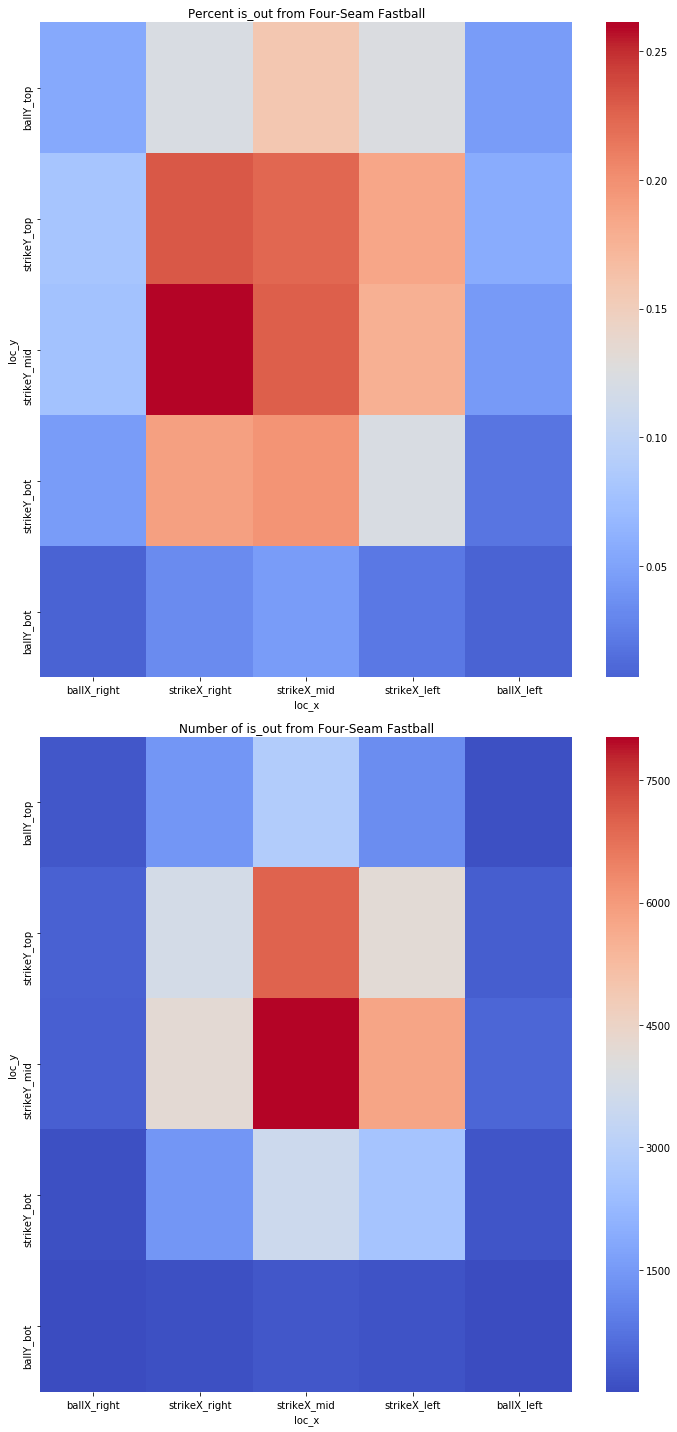

In [59]:
fsf_outs_mean, fsf_outs_count = heat_map(eda_df, bat_side = 'Right', pitch_hand = 'Right', pitch_type = 'Four-Seam Fastball', call='is_out')

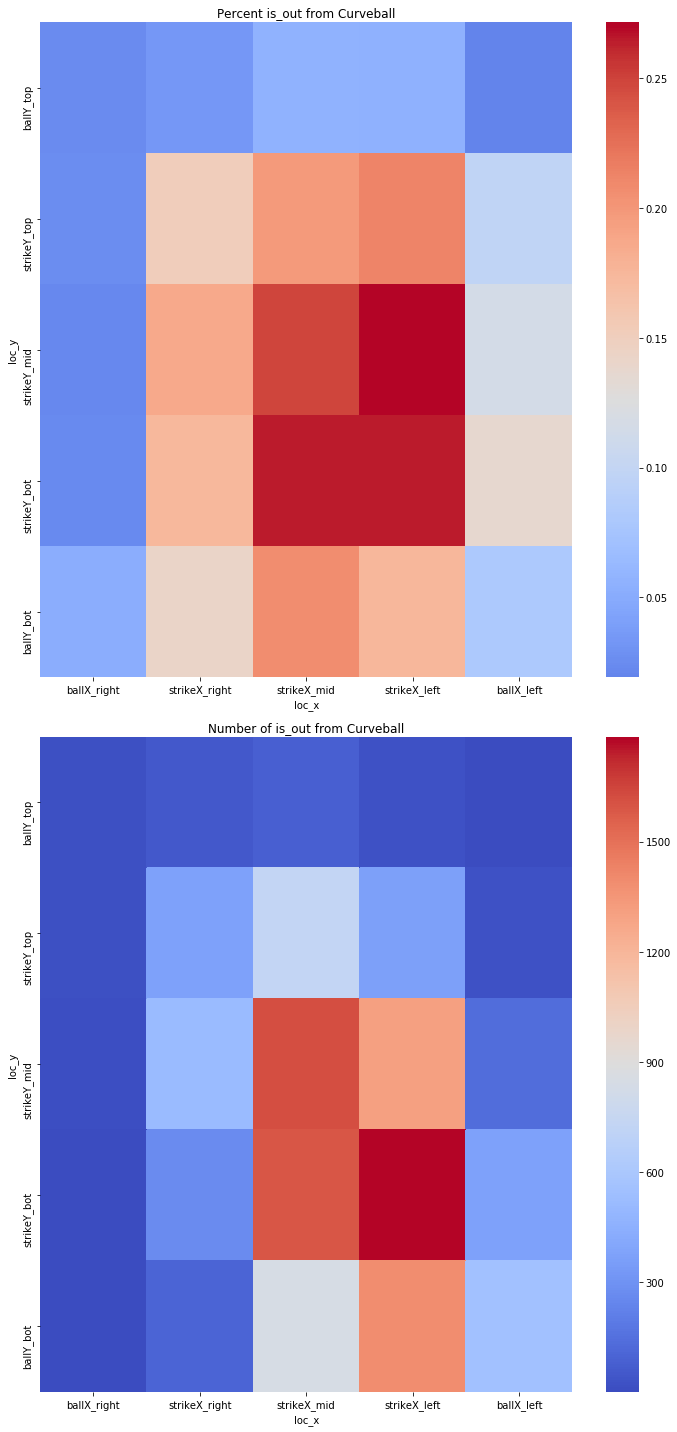

In [60]:
cu_outs_mean, cu_outs_count = heat_map(eda_df, 'Right', 'Right', 'Curveball', 'is_out')